In [1]:
from IPython.core.display import display, HTML
display(HTML('<style>body {font-family: Helvetica;}</style>'))

In [30]:

# Import libraries necessary for this project

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.metrics import r2_score

# custom modules
import helpers.boston_visuals as vs
import helpers.overunderfitting as ov


# plotting layout setup
sns.set_style(style='darkgrid')
%matplotlib inline
    
# auto reload of custom modules
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


___


# Getting Started

We will build a model that predicts the prices of homes in suburbs of Boston, Massachusetts, focusing on **performance** and **predictive power**. The data, collected in 978, comes from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Housing). More information about its features can be found [here](https://www.kaggle.com/c/boston-housing).

*Note: the source of this notebook can be found [here](https://github.com/ritchieng/machine-learning-nanodegree/tree/master/model_evaluation_prediction/boston_housing). The related article can be found [here](https://www.ritchieng.com/machine-learning-project-boston-home-prices/).*

___

# Build the Dataset

We preprocess the dataset with the following steps:

- 16 data points have an `'MEDV'` value of 50.0. These data points likely contain **missing or censored values** and have been removed. 
- 1 data point has an `'RM'` value of 8.78. This data point can be considered an **outlier** and has been removed.
- Only the features `'RM'`, `'LSTAT'`, `'PTRATIO'` are essential. The remaining **non-relevant features** have been excluded.


In [2]:
boston = vs.ModelSelector()
boston.X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 489 entries, 0 to 488
Data columns (total 3 columns):
RM         489 non-null float64
LSTAT      489 non-null float64
PTRATIO    489 non-null float64
dtypes: float64(3)
memory usage: 11.5 KB


___

# Data Exploration


1. `'RM'`: average number of rooms among homes in the neighborhood.
    - For a higher RM, one would expect to observe a higher MEDV. 
    - This is because more rooms would imply more space, thereby costing more, taking all other factors constant.
    
    
2. `'LSTAT'`: percentage of homeowners in the neighborhood considered "lower class" (working poor).
    - For a higher LSTAT, one would expect to observe a a lower MEDV.
    - The social milieux in an area dominated by "lower class" citizens may not be conducive for young children. It may also be relatively unsafe compared to an area dominated by "upper class" citizens. Hence an area with more "lower class" citizens would lower demand, hence lower prices.
    
    
  
3. `'PTRATIO'`: ratio of students to teachers in primary and secondary schools in the neighborhood.
    - For a higher LSTAT, one would expect to observe a lower MEDV.
    - This is because there would be a lower teacher-to-student ratio resulting in less attention dedicated to each student that may impair their performance in school. Typically this is the scenario in public/state schools compared to private schools. And the prices of houses around public schools are generally lower than those around private schools. Hence one would expect a lower price given a high student-to-teacher ratio due to a lower demand for houses in such areas.
    
_Note: These are merely based on intuition. These statements will be validated in the subsequent parts of this project._

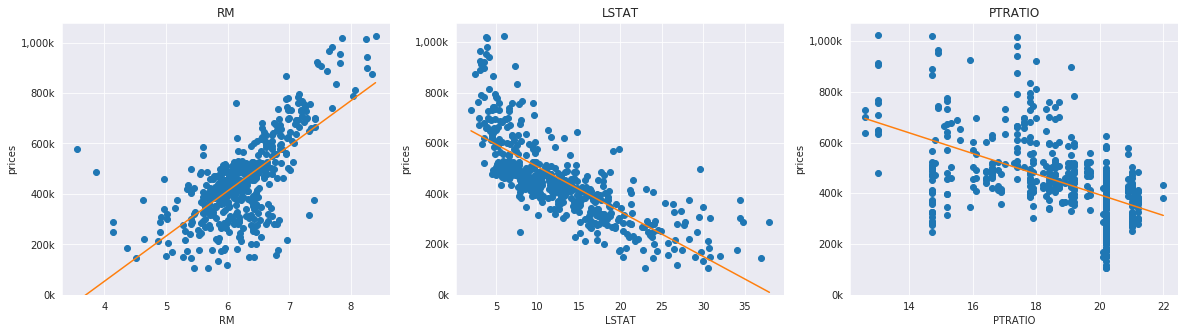

In [3]:
boston.plot_features_vs_outcome()

___


# Model Performance Metrics

We'll use the [*coefficient of determination*](http://stattrek.com/statistics/dictionary.aspx?definition=coefficient_of_determination), R<sup>2</sup>, to quantify the model's performance: It indicates what percentage of the ourcome can be explained by the model's **features**.


In [5]:

# r2 metric
def performance_metric(y_true, y_predict):
    """ Calculates and returns the performance score between 
        true and predicted values based on the metric chosen. """
    
    score = r2_score(y_true, y_predict)
    return score

# example
example = pd.DataFrame(
    np.array([[3, -0.5, 2, 7, 4.2], [2.5, 0.0, 2.1, 7.8, 5.3]]).transpose(), 
    columns=['TrueValue', 'Prediction']
)
display(example)

# r2 score
score = performance_metric(example['TrueValue'], example['Prediction'])
print("The model has a coefficient of determination, R^2, of {:.3f}.".format(score))


,TrueValue,Prediction
0,3.0,2.5
1,-0.5,0.0
2,2.0,2.1
3,7.0,7.8
4,4.2,5.3


The model has a coefficient of determination, R^2, of 0.923.


+ **92.3% of variation** is explained by the model features.
+ **Potential pitfall:** We only have five points here, so it may be hard to draw statistically significant conclusions.

___

# Analyzing Model Performance

*Note: a list of scorers is available [here](https://scikit-learn.org/stable/modules/model_evaluation.html).*

## Learning Curves

We test the performance of a decision tree model with four different maximum depths. The learning curves show the R<sup>2</sup> for both training and testing sets, as the training set gets larger. More info on learning curves can be found [here](https://scikit-learn.org/stable/modules/learning_curve.html).

_Note: the shaded region of a learning curve denotes the uncertainty of that curve (measured as one standard deviation)._

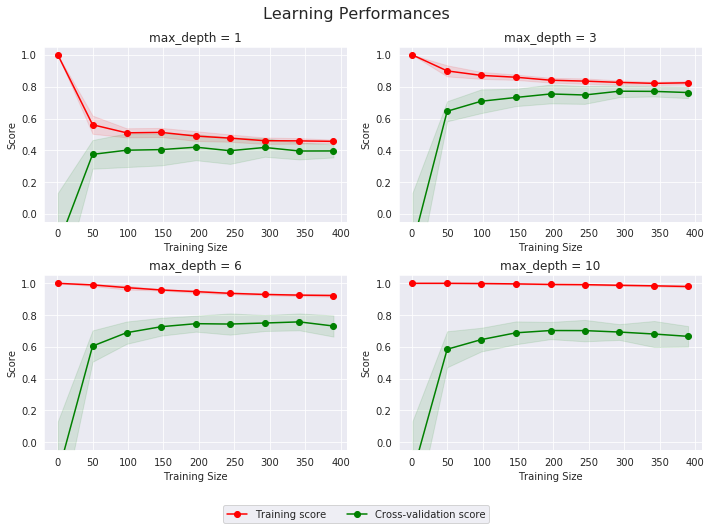

In [6]:
# Produce learning curves for varying training set sizes and maximum depths
boston.ModelLearning()

The ideal scenario shows the testing score getting closer to the training score as the training size increases, towards a high value. *This is seen above when max_depth=3, and to a lesser extent when max_depth=6.*

## Validation Curves

We test the performance of a decision tree model with various maximum depths. The learning curves show the R<sup>2</sup> for both training and testing sets, as the maximum depth increases. More information on validation curves can be found [here](https://scikit-learn.org/stable/modules/learning_curve.html#validation-curve).

_Note: using grid search is typically more suited to identifying optimal hyperparameters values._

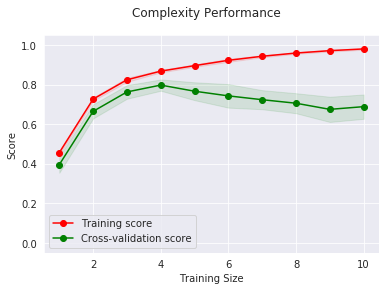

In [7]:
boston.ModelComplexity()

As shown in the validation curves, the model behavior depends on the maximum depth:

+  1: underfits the data. Both train and test scores are low.
+  4: fits the data the best. It has the highest test score, that is close to the train score.
+ 10: overfits the train set and does not generalize well.

___

# Build Model

## Hyperparameters Tuning

More information on hyperparameters tuning can be found [here](https://scikit-learn.org/stable/modules/grid_search.html).

In [8]:
reg = boston.BestModelSearch(search_method='Grid')
reg.get_params()

{'criterion': 'mse',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': 0,
 'splitter': 'best'}

In [9]:
reg = boston.BestModelSearch(search_method='Randomized')
reg.get_params()

{'criterion': 'mse',
 'max_depth': 4,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': 0,
 'splitter': 'best'}

## Predictions vs Existing Data

Now that we have confirmed that the optimal maximum depth is `4`, we'll use our best model for predictions purposes.

| Feature | Client 1 | Client 2 | Client 3 |
| :---: | :---: | :---: | :---: |
| Total number of rooms in home | 5 rooms | 4 rooms | 8 rooms |
| Neighborhood poverty level (as %) | 17% | 32% | 3% |
| Student-teacher ratio of nearby schools | 15-to-1 | 22-to-1 | 12-to-1 |

In [10]:

# Produce a matrix for client data
client_data = [[5, 17, 15], # Client 1
               [4, 32, 22], # Client 2
               [8, 3, 12]]  # Client 3


# Show predictions
print('Predicted Selling Prices:')
for i, price in enumerate(reg.predict(client_data)):
    print("Client {}: ${:,.0f}".format(i+1, np.round(price/100, 0) * 100))
    

Predicted Selling Prices:
Client 1: $408,800
Client 2: $231,300
Client 3: $938,100


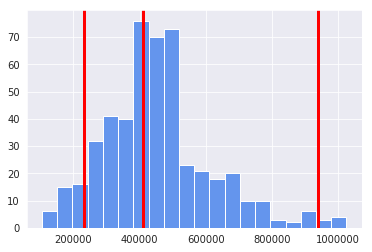

In [11]:

plt.hist(boston.y, bins = 20, color = 'cornflowerblue')
for price in reg.predict(client_data):
    plt.axvline(price, lw = 3, c = 'r')
    

## K-NearestNeighbors 

We can check if our predictions are reasonable by using K-Nearest Neighbors for our test sample.

In [12]:

# Show predictions
print('Predicted Selling Prices vs closest neighbors:')
for i, price in enumerate(reg.predict(client_data)):
    cmin, cmax = boston.avg_NearestNeighbors_price(client_data[i])
    print("Client {}: ${:,.0f} vs [${:,.0f}, ${:,.0f}]".format(i+1, np.round(price/100, 0) * 100, cmin, cmax))


Predicted Selling Prices vs closest neighbors:
Client 1: $408,800 vs [$301,409, $443,671]
Client 2: $231,300 vs [$121,335, $202,905]
Client 3: $938,100 vs [$775,715, $1,018,525]


More information about Nearest Neighbors can be found [here](http://scikit-learn.org/stable/modules/neighbors.html)

## Variance

Running the model 10 times with a different split between train and test set shows how predictions depend on the train data:

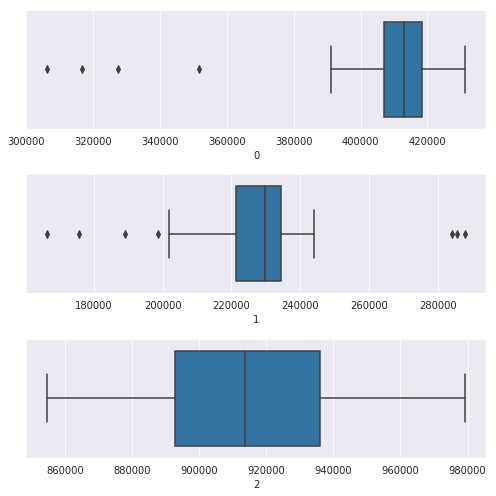

In [25]:

prices = pd.DataFrame(boston.PredictTrials(client_data, num_tests=50))

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(7,7))

for i in range(prices.shape[1]):
    _ = sns.boxplot(x=prices[i], ax=ax[i])
    
fig.tight_layout()
